# NTM - dataframe calculator
### Enrico Gavagnin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import networkx.algorithms.community as nxc
#import community
import statistics
import scipy.stats as stats
import os
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in os.listdir(working_dir) if s[15:17] == '.m'])

## Property calculator (fixed time-window)

In [3]:
# function to compute netowrk properties
def G_prop(G, exp, start, end, time_win, max_gap, name, var, PLOT_HM_check = False):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    res = 1
    
    # Best partition Louvian Method
    best_partition = nxc.louvain_communities(G, weight='weight', resolution=res)
    best_partition_CC = nxc.louvain_communities(GC, weight='weight', resolution=res)
    best_partition_CC_res_09 = nxc.louvain_communities(GC, weight='weight', resolution=0.9)
    if var != None:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=3, best_n=3, resolution=res)
        mode_p = mode_communities_dic[var['link_type']][name[11:14]][time_win]
    else:
        best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=1, best_n=1, resolution=res)
        mode_p = 1
        
    best_partition_CC_mode_p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=mode_p, best_n=mode_p, resolution=res)
    
    
    # Heatmap partition plotting (optional)
    if PLOT_HM_check:
        
        # Save HM_partition Louvain
        directory = 'plots/HM_partition/unsup_mod/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition 3 partition
        directory = 'plots/HM_partition/sup_mod3p/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_3p, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition mode parition
        directory = 'plots/HM_partition/sup_modmp/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_mode_p, 
                          directory + '/', 
                          name[7:15] + attributes)

    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'cMOD_communities': [len(best_partition_CC[i]) for i in range(len(best_partition_CC))],
            'cmpMOD_communities': [len(best_partition_CC_mode_p[i]) for i in range(len(best_partition_CC_mode_p))],
            'c3pMOD_communities': [len(best_partition_CC_3p[i]) for i in range(len(best_partition_CC_3p))],
            'cMODres09_communities': [len(best_partition_CC_res_09[i]) for i in range(len(best_partition_CC_res_09))],
            'MOD': nxc.modularity(G, best_partition),
            'cMOD': nxc.modularity(GC, best_partition_CC),
            'c3pMOD': nxc.modularity(GC, best_partition_CC_3p),
            'cmpMOD': nxc.modularity(GC, best_partition_CC_mode_p),
            'DEN': nx.density(G), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

## Heatmap partition

In [4]:
# Heatmap stack calculator

def compute_HM_stack(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    
    
    bins_x = range(0,8000, 50)
    bins_y = range(0,6000, 50)
    
    # initialise adj-matrix
    HM_stack = [np.zeros((len(bins_y)-1,len(bins_x)-1))]*N_ants

    # Populate network
    for i in fm.Query.ComputeAntTrajectories(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9)):
        
        #print(i.Positions[:,1])
        HM_stack[i.Ant - 1] = HM_stack[i.Ant - 1] + np.histogram2d(i.Positions[:,2],i.Positions[:,1], bins=[bins_y, bins_x])[0]           

    return HM_stack

# Function which plot heatmaps of partition
def PLOT_HM_partition(HM_stack, partition, fld_path, file_name):
    
    n_partition = len(partition)
    ant_list = list(frozenset().union(*list(partition)))
    
    HM_part = {p: np.zeros(np.shape(HM_stack[0])) for p in range(n_partition)}
    
    # build background
    background = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 3))
    
    for a in ant_list:
        for c in range(3):
            background[:, :, c] += HM_stack[a]
    for c in range(3):
        background[:, :, c][background[:, :, c]>0] = 1

    fig, axs = plt.subplots(int(np.ceil(n_partition / 3)), 3, figsize=(15, 10))
    c = list(sns.color_palette()) + list(sns.color_palette("Set2"))

    for part_idx in range(n_partition):
        
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(background, interpolation='gaussian')
        else:
            axs[part_idx].imshow(background, interpolation='gaussian')


        part_size = 0
        for ant in ant_list:
            if ant in partition[part_idx]:
                part_size += 1
                HM_part[part_idx] += HM_stack[ant] 
   
        
        RGB = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 4))

        mono_scale = HM_part[part_idx]
        mono_scale = mono_scale / np.nanpercentile(HM_part[part_idx], 98)
        mono_scale[mono_scale>1] = 1

        for rgb_idx in range(3): 
            RGB[:, :, rgb_idx] = c[part_idx][rgb_idx] 
        RGB[:, :, 3] = mono_scale

        # Plotting heatmap
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(RGB, interpolation='hamming') 
            axs[part_idx // 3, part_idx % 3].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))
        else:
            axs[part_idx].imshow(RGB, interpolation='hamming') 
            axs[part_idx].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))

    # remove axis 
    for idx_ax in range(int(np.ceil(n_partition / 3)) * 3):                
        if n_partition >= 4:
            axs[idx_ax // 3, idx_ax % 3].axis('off')
        else:
            axs[idx_ax].axis('off')
        

    plt.suptitle(file_name, fontweight="bold")
    plt.tight_layout()
    plt.savefig(fld_path + file_name + '.png', facecolor='white', transparent=False)
    plt.close()

## Graph calculator

In [5]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate, link_type):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones):
            
            if link_type == 'length_inter':
            # OPT1
            # WEIGHTS: cumulative interaction time
                adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
            elif link_type == '#inter':
            # OPT2
            # WEIGHTS: number of interactions
                adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
            else:
                raise TypeError('"link_type" not valid')
                

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



## Computing mode of communitites louvain

In [12]:
# Mode of communities number with louvain algorithm 

# ========== FILTERING ============
reps_discarded = [20,41]
mode_communities_dic = {}
for data_file_name in ['data/prop_data_12_6_4_3_2_1_#inter_nest_louvain_only.pkl',
                       'data/prop_data_12_6_4_3_2_1_length_inter_nest_louvain_only.pkl']:
    df = pd.read_pickle(data_file_name).drop_duplicates()
    
    if '_#inter_' in data_file_name:
        link_type = '#inter'
    elif '_length_inter_'in data_file_name:
        link_type = 'length_inter'
    
    mode_communities_dic[link_type] = {}

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
        mode_communities_dic[link_type][exp] = {}
        
        for time_win in [1, 2, 3, 4, 6, 12]:
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &  
                            (df.exp.isin([exp+'a',exp+'b'])) & 
                            (~df.rep.isin(reps_discarded))]
            
            mode_communities_dic[link_type][exp][time_win * 3600] = df_filt.partition.mode()[0]
    

a_file = open('data/mode_communities_louvain.pkl', "wb")
pickle.dump(mode_communities_dic, a_file)

## Loop myrm files

In [ ]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 

# Read file with modes of communities number computed
with open('data/mode_communities_louvain.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# maximum gap (s) for interaction computation
for link_type in ['length_inter']:#, '#inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

    print(link_type)

    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)
        
        
    
        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(60 * 60 * 24 * 10**9))

        # ======== 1H window ========
        for time_win_h in [1, 2, 3, 4, 6, 12]:
            time_win = 60 * 60 * time_win_h
            
            for tw in range(int(24/time_win_h)):
                print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
                s = start.Add(fm.Duration(tw * time_win * 10**9))
                e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

                # Compute network
                G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type)

                # variables dict
                var = {'link_type': link_type, 'time_win': time_win, 'h': tw}

                # Compute properties
                prop_df = prop_df.append(G_prop(G, exp, s, e, time_win, max_gap, myrm_file, var = var, PLOT_HM_check = False), ignore_index=True)
            
    # Save
    a_file = open('data/prop_data_12_6_4_3_2_1_' + link_type + '_nest.pkl', "wb")
    pickle.dump(prop_df, a_file)
    a_file.close()

prop_df

#inter
EG_NTM_s13_DEHa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10


Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Ti

Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Ti

Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_wi

Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h

Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s26_DENa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time

Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s28_DIAb.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time

Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s31_DEHa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - ti

Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s33_MODb.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h -

Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s36_DENa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win

Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s38_DEHb.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_w

Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s42_DIAa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_w

Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Ti

Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Ti

Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_

Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6

Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24
Time_win:2h - time_slot: #1
Time_win:2h - time_slot: #2
Time_win:2h - time_slot: #3
Time_win:2h - time_slot: #4
Time_win:2h - time_slot: #5
Time_win:2h - time_slot: #6
Time_win:2h - time_slot: #7
Time_win:2h - time_slot: #8
Time_win:2h - time_slot: #9
Time_win:2h - time_slot: #10
Time_win:2h - time_slot: #11
Time_win:2h - time_slot: #12
Time_win:3h - time_slot: #1
Time_win:3h - time_slot: #2
Time_win:3h - time_slot: #3
Time_win:3h - time_slot: #4
Time_win:3h - time_slot: #5
Time_win:3h - time_slot: #6
Time_win:3h - time_slot: #7
Time_win:3h - time_slot: #8
Time_win:4h - time_slot: #1
Time_win:4h - time_slot: #2
Time_win:4h - time_slot: #3
Time_win:4h - time_slot: #4
Time_win:4h - time_slot: #5
Time_win:4h - time_slot: #6
Time_win:6h - time_slot: #1
Time_win:6h - time_slot: #2
Time_win:6h - time_slot: #3
Time_win:6h - time_slot: #4
Time_win:12h - time_slot: #1
Time_win:12h - time_slot: #2
EG_NTM_s55_DEHa.myrmidon
Time_win:1h - ti

In [50]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 

# Read file with modes of communities number computed
with open('data/mode_communities_louvain.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# maximum gap (s) for interaction computation
for link_type in ['length_inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None).keys())

    print(link_type)

    for myrm_file in myrm_list[20:21]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)
    
        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(60 * 60 * 12 * 10**9))

        # ======== 1H window ========
        for time_win_h in [1]:
            time_win = 60 * 60 * time_win_h
            
            for tw in range(1):
                print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
                s = start.Add(fm.Duration(tw * time_win * 10**9))
                e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

                # Compute network
                G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type)

                # variables dict
                var = {'link_type': link_type, 'time_win': time_win, 'h': tw}

                # Compute properties
                G_prop(G, exp, s, e, time_win, max_gap, myrm_file, var = var, PLOT_HM_check = True)

length_inter
EG_NTM_s13_DEHa.myrmidon
Time_win:1h - time_slot: #1


In [35]:
partition = nxc.greedy_modularity_communities(G, weight='weight')
list(frozenset().union(*list(partition)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176]

### Zoning Test

In [ ]:
myrm_file = myrm_list[-2]

min_cum_duration = 0
frm_rate = 6
max_gap = 10


exp = fm.Experiment.Open(working_dir + myrm_file)
start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
             timedelta(days = -1)).strftime("%Y-%m-%d")

# ======== 12H window ========

# cumulative time window (s)
time_win = 60 * 60 * 0.05

for t in range(4):for a in range(150):
#     plt.plot(np.array(prop_tree[a][1])/(6*60), range(len(prop_tree[a][1])))
    start_g = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    start = start_g.Add(fm.Duration(t * time_win * 10**9))
    end = start.Add(fm.Duration(time_win * 10**9))
    

    N_ants = len(exp.Ants)

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    #TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}
    Q_int = fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(10*10**9),
                                            reportFullTrajectories= False)
    #G = compute_G(exp, start, end, min_cum_duration, frm_rate)


    # compute connencted components
    #Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    #GC = G.subgraph(Gcc[0])
    
    #plt.figure()
    #nx.draw(GC)
    #plt.title(GC.number_of_nodes())
    l1 = []
    for a in Q_int[1]:
        if not(2 in a.Trajectories[1].Zones):
            l1.append(a.Trajectories[1].Mean[:2])
            
            
    
    l1 = np.array(l1)
    plt.scatter(l1[:,0],l1[:,1])
    

# Propagation time expansion coefficient calculator 

In [38]:
# function to compute propagation times expansion coefficients
#def PTEC(exp, start, end, frm_rate):

min_cum_duration = 0
frm_rate = 6
max_gap = 10

prop_tree = {}


for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue
        
    print(myrm_file)

    exp = fm.Experiment.Open(working_dir + myrm_file)

    # Number of ants
    N_ants = len(exp.Ants)    


    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) + timedelta(days = -1)).strftime("%Y-%m-%d")
    start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00')) 

    time_win = 60 * 60 * 3

    prop_tree_cln = {a:[[],[],[],[]] for a in range(N_ants)}

    for tw in range(4):
        s = start.Add(fm.Duration(tw * time_win * 10**9))
        e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

        prop_tree_tw = [[[{a + 1}], [0]] for a in range(N_ants)]

        # # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
        TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=s,end=e))}

        # # # Populate network
        for i in fm.Query.ComputeAntInteractions(exp,start=s,end=e,maximumGap=fm.Duration(max_gap*10**9),
                                                reportFullTrajectories= False)[1]:
            # Focus on Nest zone (id=1)
            for focal_ant in range(N_ants):
                if (1 in i.Trajectories[1].Zones) & (len(prop_tree_tw[focal_ant][0][-1].intersection(set(i.IDs))) == 1) & (TimeToFrame[fm.Time.ToTimestamp(i.Start)] > prop_tree_tw[focal_ant][1][-1]):
                   # if np.random.rand()< ?: # stochastic propagation ?
                        prop_tree_tw[focal_ant][0].append(prop_tree_tw[focal_ant][0][-1].union(set(i.IDs)))
                        prop_tree_tw[focal_ant][1].append(TimeToFrame[fm.Time.ToTimestamp(i.Start)])

        for focal_ant in range(N_ants):
            prop_tree_cln[focal_ant][tw] = prop_tree_tw[focal_ant][1] 

    prop_tree[myrm_file[7:15]] = prop_tree_cln

with open('data/propagation_trees_data.pkl', 'wb') as f:
    pickle.dump(prop_tree, f)
    
print('COMPLETED SUCCESSFULLY')


EG_NTM_s13_DEHa.myrmidon
EG_NTM_s13_DEHb.myrmidon
EG_NTM_s14_MODa.myrmidon
EG_NTM_s14_MODb.myrmidon
EG_NTM_s15_DENa.myrmidon
EG_NTM_s15_DENb.myrmidon
EG_NTM_s16_DIAa.myrmidon
EG_NTM_s16_DIAb.myrmidon
EG_NTM_s17_MODa.myrmidon
EG_NTM_s17_MODb.myrmidon
EG_NTM_s18_DENa.myrmidon
EG_NTM_s18_DENb.myrmidon
EG_NTM_s19_DIAa.myrmidon
EG_NTM_s19_DIAb.myrmidon
EG_NTM_s20_DEHa.myrmidon
EG_NTM_s20_DEHb.myrmidon
EG_NTM_s21_DIAa.myrmidon
EG_NTM_s21_DIAb.myrmidon
EG_NTM_s22_MODa.myrmidon
EG_NTM_s22_MODb.myrmidon
EG_NTM_s23_DENa.myrmidon
EG_NTM_s23_DENb.myrmidon
EG_NTM_s24_DEHa.myrmidon
EG_NTM_s24_DEHb.myrmidon
EG_NTM_s25_DEHa.myrmidon
EG_NTM_s25_DEHb.myrmidon
EG_NTM_s26_DENa.myrmidon
EG_NTM_s26_DENb.myrmidon
EG_NTM_s27_MODa.myrmidon
EG_NTM_s27_MODb.myrmidon
EG_NTM_s28_DIAa.myrmidon
EG_NTM_s28_DIAb.myrmidon
EG_NTM_s29_DENa.myrmidon
EG_NTM_s29_DENb.myrmidon
EG_NTM_s30_MODa.myrmidon
EG_NTM_s30_MODb.myrmidon
EG_NTM_s31_DEHa.myrmidon
EG_NTM_s31_DEHb.myrmidon
EG_NTM_s32_DIAa.myrmidon
EG_NTM_s32_DIAb.myrmidon


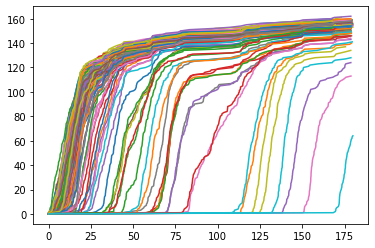

In [33]:
for a in range(140):
    plt.plot(np.array(prop_tree_tw[a][1])/(6*60), range(len(prop_tree_tw[a][1])))
# prop_tree_dict = {a:[[],[],[],[]] for a in range(N_ants)}
# prop_tree_dict = [[[],[],[],[]] for a in N_ants]
# prop_tree_dict[0][0] = prop_tree[0][1]
# prop_tree_dict

# with open('data/propagation_trees_data.pkl', 'rb') as f:
#     prop_tree = pickle.load(f)
# prop_tree


# Connectivity Dataframe (Gcc_df)

In [ ]:
# Time vs Connectivity

def compute_Gcc(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))
    
    Gcc = [[sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True)],
           [0]]

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones) & (adj_mat[i.IDs[0]-1, i.IDs[1]-1] == 0):
            
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] = 1           
         
            if i.Start.After(start.Add(fm.Duration((Gcc[1][-1] + 1) * 10**9))):
    
                Gcc[0].append(sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True))
                Gcc[1].append(Gcc[1][-1] + 1)
                    
    # network build
    return   Gcc



## ============= LOOP =============== 

Gcc_df = pd.DataFrame(columns=['rep', 'exp', 'Gcc'])
max_gap = 10
for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue

    print(myrm_file)

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    ## ------ Time window ------ 
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    start_time = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    
    Gcc = compute_Gcc(exp,start_time,start_time.Add(fm.Duration(12 * 60 * 60 * 10**9)))
    
    Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)

    
# Save
a_file = open("data/Gcc_NEST.pkl", "wb")
pickle.dump(Gcc_df, a_file)
a_file.close()


EG_NTM_s13_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s13_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s50_DIAa.myrmidon
